In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# Read the train data
train_faces = pd.read_csv('dataset/train/train_faces.csv')


# Read the test data
test_faces_dir = 'dataset/test/faces/'
test_faces_filenames = sorted(os.listdir(test_faces_dir))

In [2]:
train_faces.shape

(99, 37)

In [3]:
#ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

In [4]:
train_faces = pd.read_csv("dataset/train/train_faces.csv", dtype=dt)

num_splits = 6

In [5]:
from tqdm import tqdm

# a function that loads the all the images directly
# each image is cut into 36 puzzle pieces and each piece is stored as a seperate array
def load_images_faces(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("dataset/train/faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [6]:
def load_images_faces_test(filenames):
    ret = []
    for filename in tqdm(filenames):
        pieces = []
        img = Image.open('dataset/test/faces/'+filename).convert('RGB')
        img_array = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img_array[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [7]:
#train test split
n = len(train_faces)

val_split = 0.2

faces_val_df = train_faces[:int(n*val_split)]
faces_train_df = train_faces[int(n*val_split):]


In [8]:
X_train_faces = load_images_faces(faces_train_df)
X_val_faces = load_images_faces(faces_val_df)

print(X_train_faces.shape)
print(X_val_faces.shape)

100%|██████████| 19/19 [00:00<00:00, 337.01it/s]

(80, 36, 50, 50, 3)
(19, 36, 50, 50, 3)


In [9]:

X_test_faces = load_images_faces_test(test_faces_filenames)

print(f"X_test_faces shape: {X_test_faces.shape}") # check the shape of X_test_faces

100%|██████████| 900/900 [00:03<00:00, 296.03it/s]


X_test_faces shape: (900, 36, 50, 50, 3)


In [10]:
'''
a function that one hot encodes the given labels.
we have a total of 36 puzzle pieces and 36 possible positions for each of those pieces
if piece at index i has its correct position at index j, we make label[i][j] = 1 
and all the other values in label[i] are set to 0

we iterate through all positions using i and j.
for each position, its index out of 36 will be i*6+j 
and same for the value in that column
'''

def load_labels_faces(train_faces):
    ret = []
    for idx in tqdm(train_faces.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(train_faces.loc[idx, str(i)+str(j)][0])*6 + int(train_faces.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)


In [11]:
y_train_faces = load_labels_faces(faces_train_df)
y_val_faces = load_labels_faces(faces_val_df)

print(y_train_faces.shape)
print(y_val_faces.shape)

100%|██████████| 19/19 [00:00<00:00, 828.35it/s]

(80, 36, 36)
(19, 36, 36)


In [12]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("dataset/test/faces/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

In [13]:
import tensorflow as tf
import keras
from keras.layers import TimeDistributed as td
from keras.layers import Conv2D, Flatten, Dense, ZeroPadding2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape

inp = tf.keras.layers.Input(shape=(36, 50, 50, 3)) #input all puzzle pieces at once

#layers 
conv1 = tf.keras.layers.Conv2D(50, kernel_size=(5, 5), padding='same', activation='relu', strides=2)
b1 = tf.keras.layers.BatchNormalization()
mp1 = tf.keras.layers.MaxPooling2D()

conv2 = tf.keras.layers.Conv2D(100, kernel_size=(5, 5), padding='same', activation='relu', strides=2)
b2 = tf.keras.layers.BatchNormalization()
d1 = tf.keras.layers.Dropout(0.3)

conv3 = tf.keras.layers.Conv2D(100, kernel_size=(3, 3), padding='same', activation='relu', strides=2)
b3 = tf.keras.layers.BatchNormalization()
d2 = tf.keras.layers.Dropout(0.3)

conv4 = tf.keras.layers.Conv2D(200, kernel_size=(3, 3), padding='same', activation='relu', strides=1)
b4 = tf.keras.layers.BatchNormalization()
d3 = tf.keras.layers.Dropout(0.3)

flat = tf.keras.layers.Flatten()

dense1 = tf.keras.layers.Dense(900, activation='relu')
b5 = tf.keras.layers.BatchNormalization()

dense2 = tf.keras.layers.Dense(600, activation='relu')
b6 = tf.keras.layers.BatchNormalization()    
d4 = tf.keras.layers.Dropout(0.3)

dense3 = tf.keras.layers.Dense(36)


#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = b1(x)
    x = mp1(x)
    x = conv2(x)
    x = b2(x)
    x = d1(x)
    x = conv3(x)
    x = b3(x)
    x = d2(x)
    x = conv4(x)
    x = b4(x)
    x = d3(x)

    x = flat(x)
    x = dense1(x)
    x = b5(x)
    x = dense2(x)
    x = b6(x)
    x = d4(x)
    x = dense3(x)
    mid.append(x)

x = tf.keras.layers.concatenate(mid, axis=-1)
x = tf.keras.layers.Reshape((36,36))(x)
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

In [14]:
from tensorflow import keras
opt = tf.keras.optimizers.Adam()

In [15]:
model_faces = tf.keras.Model(inputs=inp, outputs=x)
model_faces.compile(optimizer=opt, loss="categorical_crossentropy")

In [16]:
model_faces.fit(x = X_train_faces, 
        y = y_train_faces, 
        batch_size = 32, 
        validation_data = [X_val_faces, y_val_faces], 
        shuffle = True,
        epochs = 50)

Epoch 1/50
3/3 [==============================] - 51s 5s/step - loss: 4.6268 - val_loss: 3.6899
Epoch 2/50
3/3 [==============================] - 7s 2s/step - loss: 4.1276 - val_loss: 3.4959
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 3.9223 - val_loss: 3.4353
Epoch 4/50
3/3 [==============================] - 8s 2s/step - loss: 3.8044 - val_loss: 3.1569
Epoch 5/50
3/3 [==============================] - 8s 2s/step - loss: 3.5879 - val_loss: 3.1683
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 3.4717 - val_loss: 3.1084
Epoch 7/50
3/3 [==============================] - 8s 2s/step - loss: 3.3507 - val_loss: 2.9816
Epoch 8/50
3/3 [==============================] - 8s 3s/step - loss: 3.2344 - val_loss: 2.9311
Epoch 9/50
3/3 [==============================] - 9s 3s/step - loss: 3.2302 - val_loss: 2.8739
Epoch 10/50
3/3 [==============================] - 9s 3s/step - loss: 3.1004 - val_loss: 2.9108
Epoch 11/50
3/3 [==============================]

In [30]:
model_faces.save('model_faces.h5')

In [17]:
pred_faces = model_faces.predict(X_test_faces)
pred_faces = np.argmax(pred_faces, axis=-1)
print(pred_faces.shape)
print(pred_faces)

29/29 [==============================] - 27s 622ms/step
(900, 36)
[[ 7 21  9 ... 17 11 10]
 [21  3  8 ...  5 28 11]
 [ 9 17 27 ... 13 17 13]
 ...
 [24 31 24 ... 26 24 31]
 [11 14  6 ...  0 15 31]
 [29 14 31 ... 31 10 29]]


In [18]:
#face dataframe
#formatting our predictions into pandas dataframe
pred_list = []
for i in range(pred_faces.shape[0]):
    t = []
    for j in range(pred_faces[i].shape[0]):
        t.append(str(pred_faces[i][j]//6) + str(pred_faces[i][j]%6))
    pred_list.append(t)

image_df = pd.DataFrame(test_faces_filenames)
label_df = pd.DataFrame(pred_list)
faces_df = pd.concat([image_df, label_df], axis=1)
faces_df.columns = train_faces.columns

In [19]:
faces_df.head()

image  00  01  02  03  04  05  10  11  12  ...  42  43  44  45  \
0  00iOHCZTws.jpg  11  33  13  53  02  23  42  12  15  ...  43  15  21  15   
1  03fxX7jYxI.jpg  33  03  12  15  30  51  14  15  02  ...  03  15  31  42   
2  05evYM76RD.jpg  13  25  43  42  44  15  11  15  45  ...  31  12  15  55   
3  08UaxmNJtO.jpg  23  44  22  45  25  40  42  33  43  ...  33  42  03  12   
4  09gb5hcslV.jpg  40  44  23  10  52  25  20  13  43  ...  32  35  24  00   

   50  51  52  53  54  55  
0  03  52  22  25  15  14  
1  51  43  02  05  44  15  
2  32  02  15  21  25  21  
3  54  51  32  24  00  10  
4  02  02  01  13  42  03  

[5 rows x 37 columns]

C:\Users\soniv\AppData\Local\Temp\ipykernel_23192\260241591.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

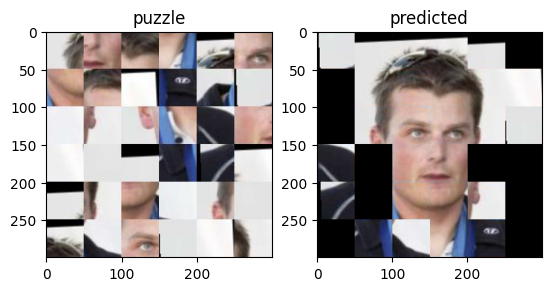

<Figure size 640x480 with 0 Axes>

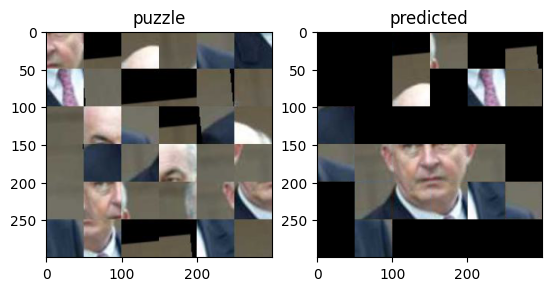

<Figure size 640x480 with 0 Axes>

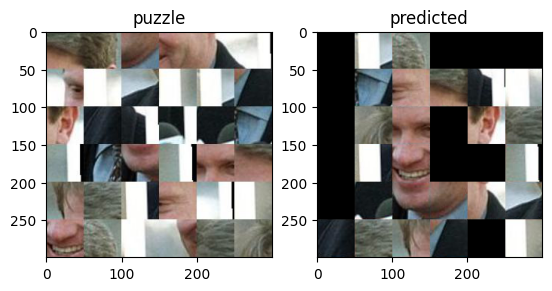

<Figure size 640x480 with 0 Axes>

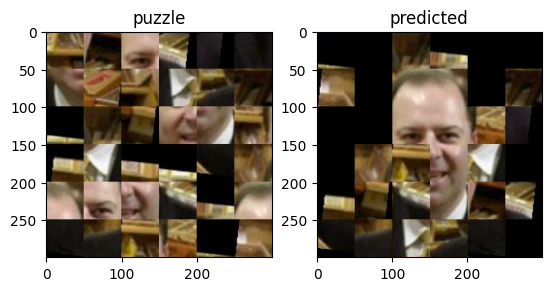

<Figure size 640x480 with 0 Axes>

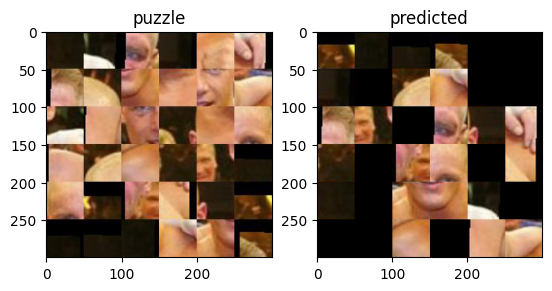

<Figure size 640x480 with 0 Axes>

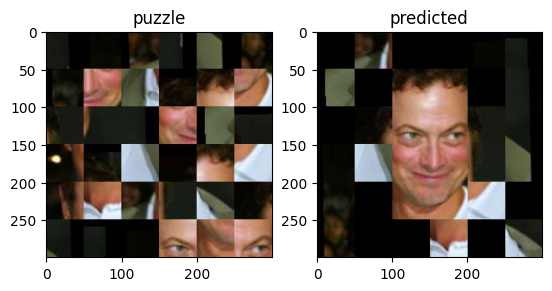

<Figure size 640x480 with 0 Axes>

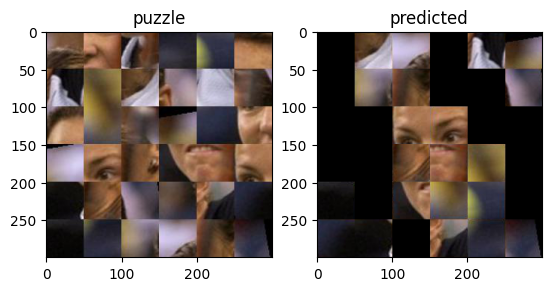

<Figure size 640x480 with 0 Axes>

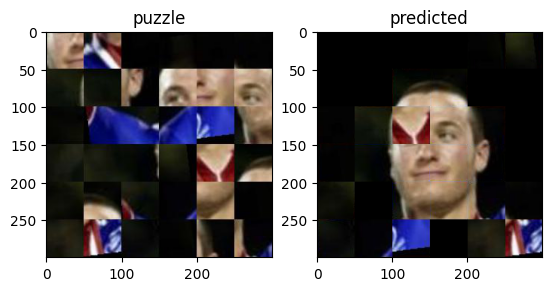

<Figure size 640x480 with 0 Axes>

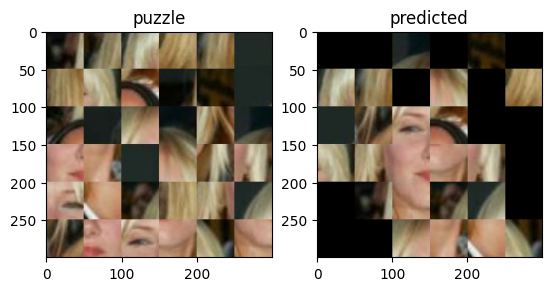

<Figure size 640x480 with 0 Axes>

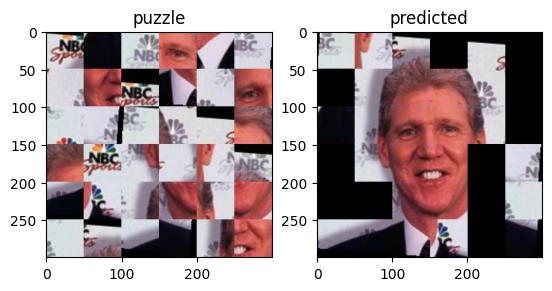

<Figure size 640x480 with 0 Axes>

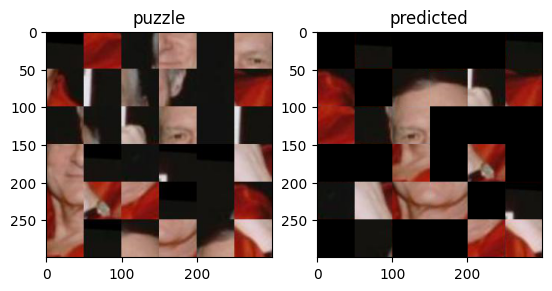

<Figure size 640x480 with 0 Axes>

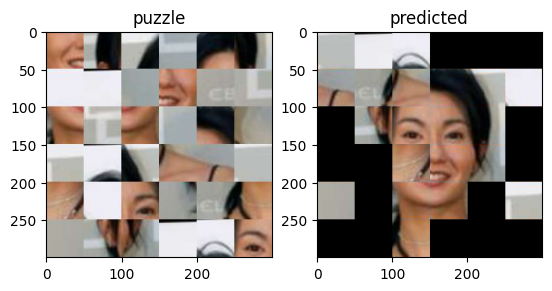

<Figure size 640x480 with 0 Axes>

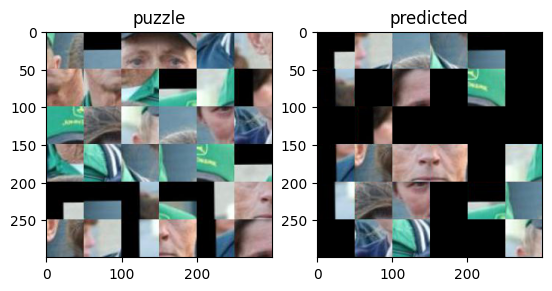

<Figure size 640x480 with 0 Axes>

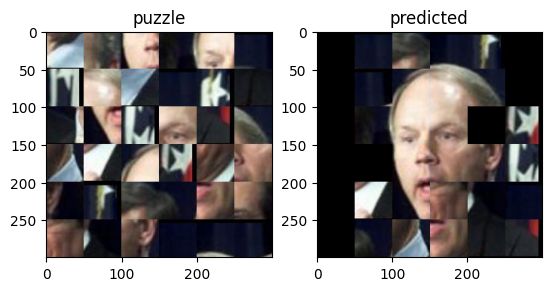

<Figure size 640x480 with 0 Axes>

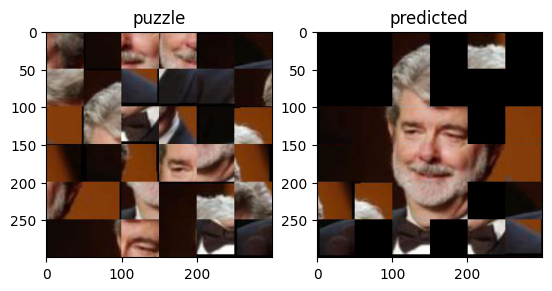

<Figure size 640x480 with 0 Axes>

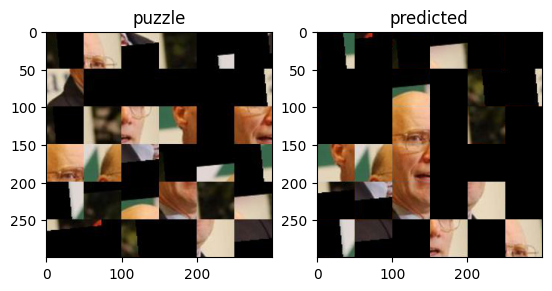

<Figure size 640x480 with 0 Axes>

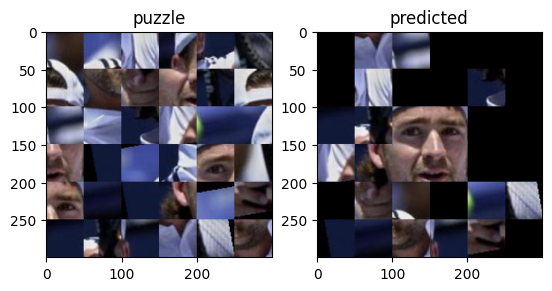

<Figure size 640x480 with 0 Axes>

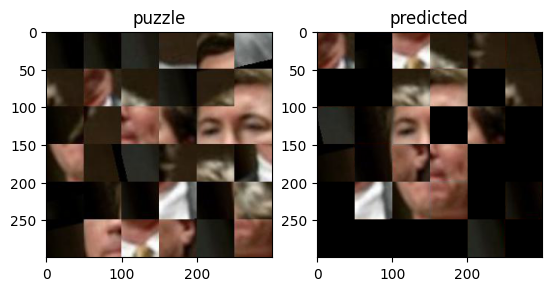

<Figure size 640x480 with 0 Axes>

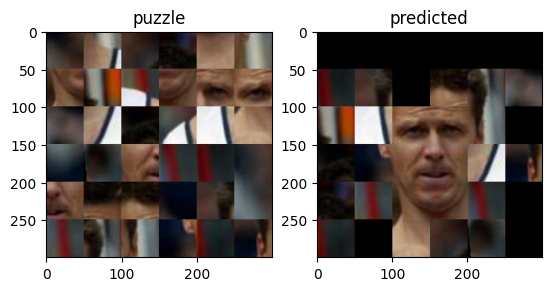

<Figure size 640x480 with 0 Axes>

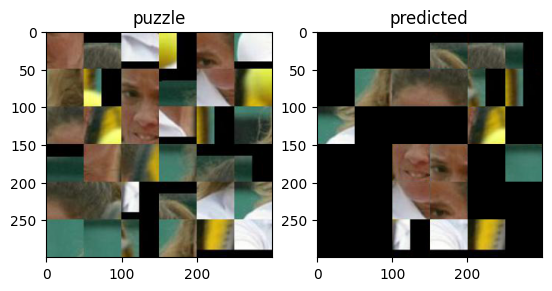

<Figure size 640x480 with 0 Axes>

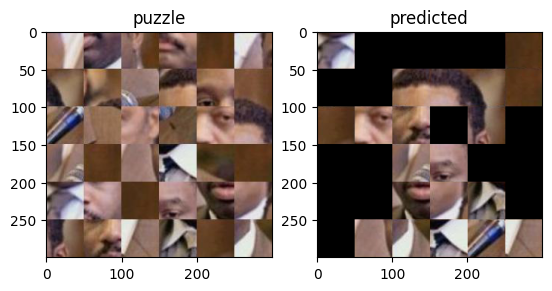

<Figure size 640x480 with 0 Axes>

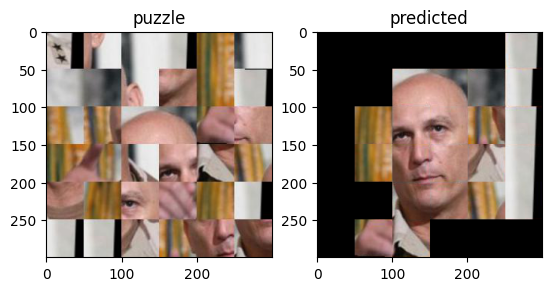

<Figure size 640x480 with 0 Axes>

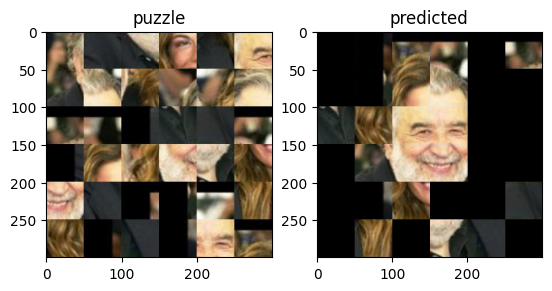

<Figure size 640x480 with 0 Axes>

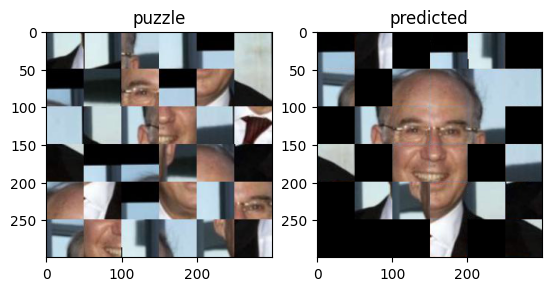

<Figure size 640x480 with 0 Axes>

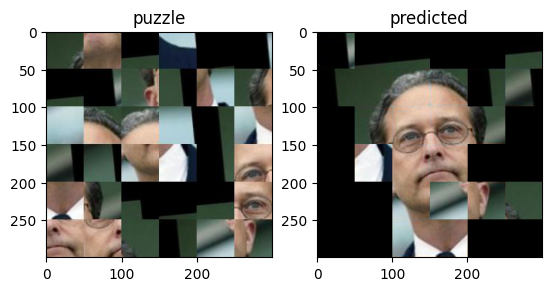

<Figure size 640x480 with 0 Axes>

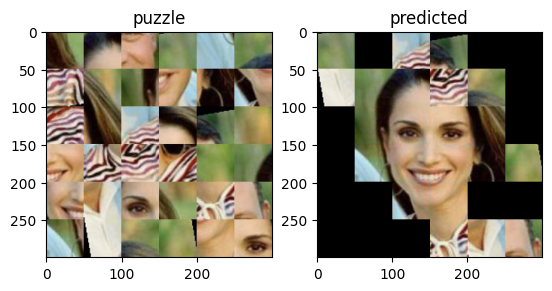

<Figure size 640x480 with 0 Axes>

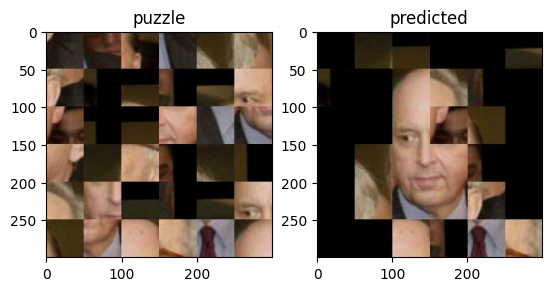

<Figure size 640x480 with 0 Axes>

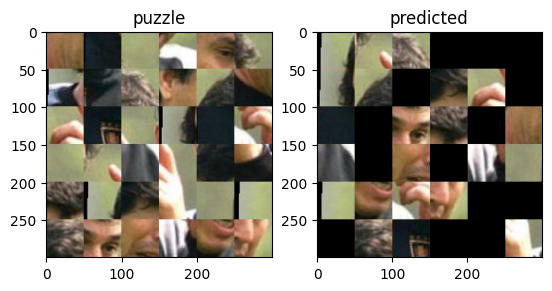

<Figure size 640x480 with 0 Axes>

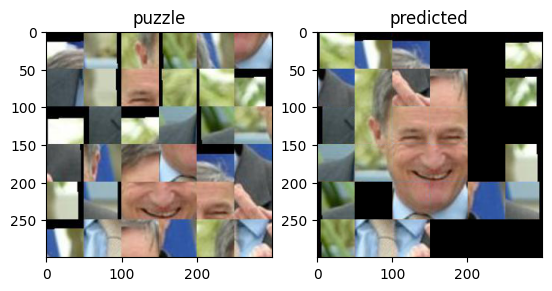

<Figure size 640x480 with 0 Axes>

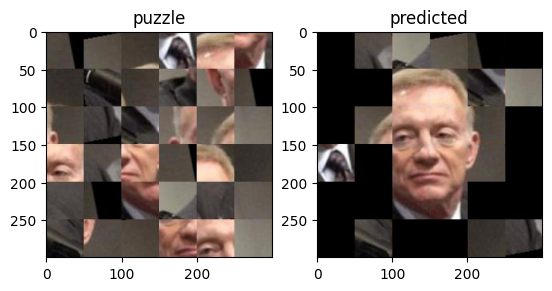

In [27]:
import matplotlib.pyplot as plt

for i in range(30):
    puzzle, solved = rearrange(faces_df, i)

    plt.figure()
    f, axarr = plt.subplots(1,2) 
    axarr[0].imshow(puzzle)
    axarr[0].set_title("puzzle")
    axarr[1].imshow(solved)
    axarr[1].set_title("predicted")
